# Credit Worthiness Research

## Sprint 1

**Aim**: Train a machine learning model on provided data to illustrate proof-of-concept (POC) for Credit Risk Modeling

**Dataset used**: credit_risk_dataset on main branch of github repository

### INTRODUCTION
Credit risk modeling  is a technique used by lenders to determine the level of credit risk associated with extending credit to a borrower.


In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score

In [2]:
# Read in the dataset

credit_data = pd.read_csv('/content/credit_risk_dataset.csv')
credit_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [9]:
print(f"There are {credit_data.shape[0]} loan instances in the dataset.")

print("Out of which...")
print(f"{credit_data.loan_status.value_counts()[0]} are Non-defaulters and {credit_data.loan_status.value_counts()[1]} are defaulters")
print("A Defaulter is someone who fails to repay a loan.")

There are 32581 loan instances in the dataset
Out of which...
25473 are Non-defaulters and 7108 are defaulters
A Defaulter is someone who fails to repay a loan


***The Dataset is imbalanced having a greater number of non-defaulters***

In [10]:
# Check columns with missing values
credit_data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

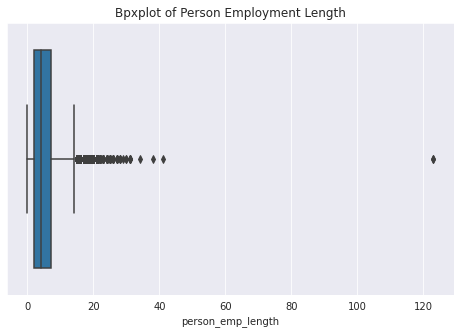

In [27]:
# Plot a visual of `person_emp_length`
plt.figure(figsize=(8, 5))
sns.boxplot(x =credit_data['person_emp_length'])
plt.title('Boxplot of Person Employment Length')
plt.show()

In [28]:
# Impute missing values using the median value
credit_data['person_emp_length'] = credit_data['person_emp_length'].\
            fillna(credit_data['person_emp_length'].median())

#  Remove the outliers
indices = credit_data[credit_data['person_emp_length'] >= 120].index
credit_data = credit_data.drop(indices)

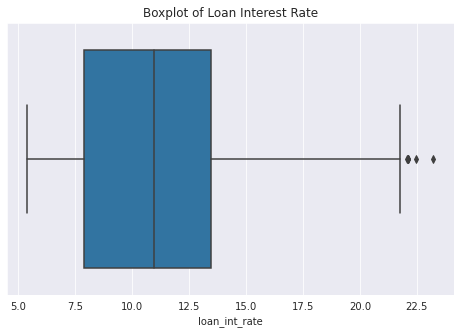

In [32]:
# Plot a visual of `person_emp_length`
plt.figure(figsize=(8, 5))
sns.boxplot(x=credit_data['loan_int_rate'])
plt.title('Boxplot of Loan Interest Rate')
plt.show()

In [33]:
# Impute missing values using the median value
credit_data['loan_int_rate'] = credit_data['loan_int_rate'].\
            fillna(credit_data['loan_int_rate'].median())

In [53]:
# Separate Numeric and Non-Numeric COlumns

credit_num = credit_data.select_dtypes(exclude = ['object'])
credit_cat = credit_data.select_dtypes(include = ['object'])

# Perform One hot Encoding
credit_cat_onehot = pd.get_dummies(credit_cat, drop_first=True)

credit_processed = pd.concat([credit_num, credit_cat_onehot], axis=1)

# Get the independent variables and dependent variable
y = credit_processed['loan_status']
X = credit_processed.drop('loan_status', axis=1)

# Split Data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)


# Instantiate base classifier
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Output predicted probability, and set threshold of 0.5
preds = log_reg.predict_proba(X_test)
preds_df = pd.DataFrame(preds[:, 1], columns = ['prob_default'])
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.3 else 0)            

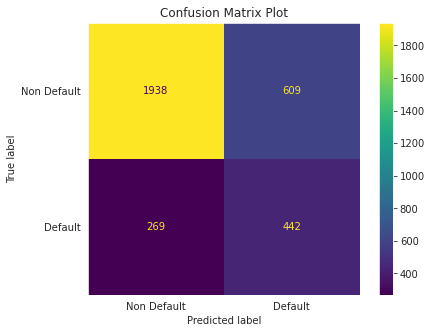

In [54]:
# Visualize Confusion Matrix
class_names = ['Non Default', 'Default']

conf_mat = confusion_matrix(y_test, preds_df['loan_status'], labels = log_reg.classes_)

disp = ConfusionMatrixDisplay(conf_mat, display_labels = class_names)

fig, ax = plt.subplots(figsize=(7, 5))
disp.plot(ax=ax)
plt.grid(None)
plt.title('Confusion Matrix Plot')
plt.show()

In [55]:
auc = roc_auc_score(y_test, preds_df['loan_status'])
print(f"AUC score is {auc}")

AUC score is 0.6912774025535129


In [57]:
import joblib

joblib.dump(log_reg, 'log_reg.pkl')

['log_reg.pkl']

In [58]:
# Serving Function
def cater_for_inference(data):
  """SOme preprocessing still needed based on the input data"""
  log_reg_model = joblib.load('log_reg.pkl')
  predicted = log_reg_model.predict(data)
  prob = log_reg_model.predict_proba(data)[:, 1]
  return predicted, prob